# Implementation of Vanilla GANs model
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [1]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [4]:
import numpy as np
import datetime
import os, sys

In [5]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [6]:
MODEL_NAME = 'VanillaGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [8]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [9]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )

    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [10]:
n_noise = 100

In [11]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [12]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [13]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.60MB/s]


In [14]:
batch_size = 64

In [15]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [16]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [17]:
max_epoch = 50 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [18]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [19]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [20]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/50, Step: 0, D Loss: 1.412089228630066, G Loss: 0.6705775260925293
Epoch: 0/50, Step: 500, D Loss: 1.3077036142349243, G Loss: 1.3537261486053467
Epoch: 1/50, Step: 1000, D Loss: 1.1126117706298828, G Loss: 0.904180645942688
Epoch: 1/50, Step: 1500, D Loss: 1.3146312236785889, G Loss: 0.590653121471405
Epoch: 2/50, Step: 2000, D Loss: 1.1899877786636353, G Loss: 1.189957618713379
Epoch: 2/50, Step: 2500, D Loss: 1.1508790254592896, G Loss: 1.055232048034668
Epoch: 3/50, Step: 3000, D Loss: 1.2632321119308472, G Loss: 0.6603822708129883
Epoch: 3/50, Step: 3500, D Loss: 1.0848788022994995, G Loss: 1.0496728420257568
Epoch: 4/50, Step: 4000, D Loss: 1.2470896244049072, G Loss: 0.8553764820098877
Epoch: 4/50, Step: 4500, D Loss: 1.2719264030456543, G Loss: 1.111085057258606
Epoch: 5/50, Step: 5000, D Loss: 1.3960987329483032, G Loss: 0.6319018006324768
Epoch: 5/50, Step: 5500, D Loss: 1.388213872909546, G Loss: 1.2289730310440063
Epoch: 6/50, Step: 6000, D Loss: 1.2253146171569824

## Visualize Sample

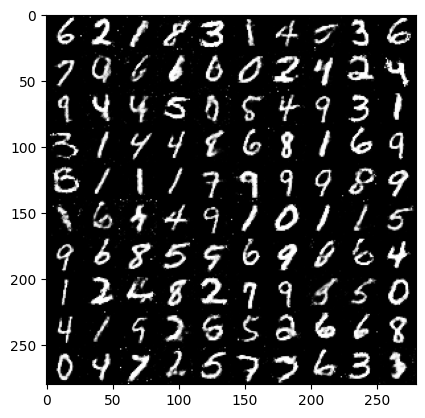

In [21]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [22]:
# Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')